In [234]:
!pip install tensorflow_addons

     |████████████████████████████████| 703 kB 4.5 MB/s eta 0:00:01


In [235]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [4]:
# pip install keras

In [5]:
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf
import cv2

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [7]:
train_path = '/home/vraskap3/datas/train/data/'#enter path to training data
test_path = '/home/vraskap3/datas/test/data/'#enter path to testing data
mask_path = '/home/vraskap3/datas/masks/'
output_path = '/home/vraskap3/datas/output/'

In [8]:
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]
# print(test_ids)

In [9]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [10]:
print("X_train",X_train.shape)
print("Y_train",Y_train.shape)

X_train (211, 256, 256, 3)
Y_train (211, 256, 256, 1)


In [11]:
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

Getting and resizing train images and masks ... 


In [33]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
#     input_mask -= 1
    return input_image, input_mask

In [34]:
# @tf.function
def load_image_train(image, mask):
    input_image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    input_mask = tf.image.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [35]:
def load_image_test(image):
    input_image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    input_image, input_mask = normalize(input_image, None)

    return input_image

In [15]:
def display(display_list):
    plt.figure(figsize=(40, 40))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        print(i)
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_WIDTH, IMG_HEIGHT, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [17]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [18]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3])

  # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
OUTPUT_CHANNELS = 3

In [236]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [237]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 96 1841984     input_3[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 512)  1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 16, 16, 1088) 0           sequential[1][0]                 
                                                                 model[1][3]                

In [238]:
tf_tensors_images = []
tf_tensors_masks = []
for n, ids in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path + ids +'/'
    image = imread(path +'frame0000.png')[:,:]
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)

    mask_one = imread(mask_path + ids + '.png')[:,:]
    mask = resize(mask_one, (IMG_HEIGHT, IMG_WIDTH, 1), preserve_range=True)

    in_image, in_mask = load_image_train(image, mask)
    tf_tensors_images.append(in_image)
    tf_tensors_masks.append(in_mask)

100%|██████████| 211/211 [00:07<00:00, 27.25it/s]


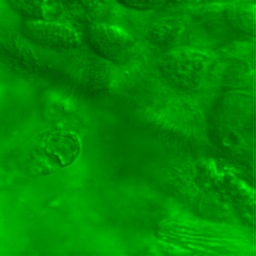

In [239]:
tf.keras.preprocessing.image.array_to_img(tf_tensors_images[0])

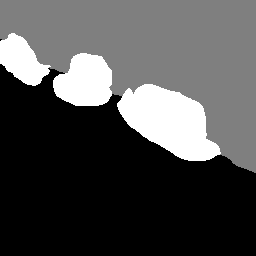

In [240]:
tf.keras.preprocessing.image.array_to_img(tf_tensors_masks[0])

In [241]:
dataset = tf.data.Dataset.from_tensor_slices((tf_tensors_images, tf_tensors_masks))

In [242]:
dataset

<TensorSliceDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.float32)>

In [243]:
BUFFER_SIZE = 211
BATCH_SIZE = 16
train = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [244]:
train

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [245]:
history = model.fit(train, 
                    epochs=10,
                    steps_per_epoch=16
                   )

Epoch 1/10


ValueError: in user code:

    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/keras_utils.py:61 call  *
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow_addons/losses/giou_loss.py:90 giou_loss  *
        giou = tf.squeeze(_calculate_giou(y_pred, y_true, mode))
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow_addons/losses/giou_loss.py:108 _calculate_giou  *
        b1_ymin, b1_xmin, b1_ymax, b1_xmax = tf.unstack(b1, 4, axis=-1)
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:1582 unstack
        return gen_array_ops.unpack(value, num=num, axis=axis, name=name)
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:12097 unpack
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/miniconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension must be 4 but is 3 for '{{node giou_loss/unstack}} = Unpack[T=DT_FLOAT, axis=-1, num=4](model_2/conv2d_transpose_5/BiasAdd)' with input shapes: [?,256,256,3].


In [ ]:
history

In [224]:
test_tensors_images = []
test_image_shapes = []
for n, ids in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + ids +'/'
    image = imread(path +'frame0000.png')[:,:]
    test_image_shapes.append(image.shape)
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True)


    in_image = load_image_test(image)
    test_tensors_images.append(in_image)

100%|██████████| 114/114 [00:03<00:00, 35.65it/s]


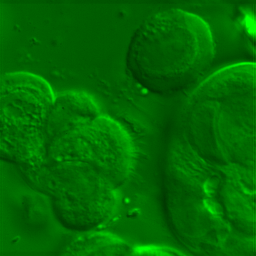

In [225]:
tf.keras.preprocessing.image.array_to_img(test_tensors_images[0])

In [226]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_tensors_images))
# pred_mask = model.predict(test_tensors_images[0])

In [227]:
test_dataset

<TensorSliceDataset shapes: (256, 256, 3), types: tf.float32>

In [228]:
BUFFER_SIZE = 114
BATCH_SIZE = 1
test = test_dataset.cache().batch(BATCH_SIZE)

In [229]:
len(test)

114

In [230]:
im = []
mk = []
i = 0
output_path = '/home/vraskap3/datas/new_ouput'
for image in test:
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    im = image[0]
    mk = pred_mask[0]
    print(test_image_shapes[i])
    mk = tf.image.resize(mk, test_image_shapes[i], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False, antialias=False, name=None)
    tf.keras.preprocessing.image.save_img(f'{output_path}/{test_ids[i]}.png', mk)
    i += 1

(256, 256)
(256, 256)
(384, 512)
(256, 256)
(256, 256)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(480, 640)
(480, 640)
(256, 640)
(480, 640)
(256, 256)
(480, 640)
(256, 640)
(256, 256)
(480, 640)
(480, 640)
(512, 512)
(256, 256)
(480, 640)
(256, 256)
(256, 256)
(384, 256)
(256, 256)
(256, 256)
(384, 512)
(512, 256)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(512, 256)
(256, 256)
(384, 512)
(480, 640)
(480, 640)
(256, 256)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(256, 256)
(240, 320)
(480, 640)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(256, 256)
(512, 512)
(256, 256)
(480, 640)
(256, 256)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(256, 256)
(256, 256)
(256, 256)
(480, 640)
(480, 640)
(240, 320)
(256, 256)
(240, 320)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(480, 640)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(256, 256)
(480, 640)
(480, 640)
(480, 640)

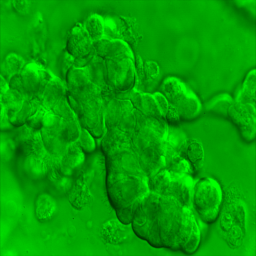

In [231]:
tf.keras.preprocessing.image.array_to_img(im)

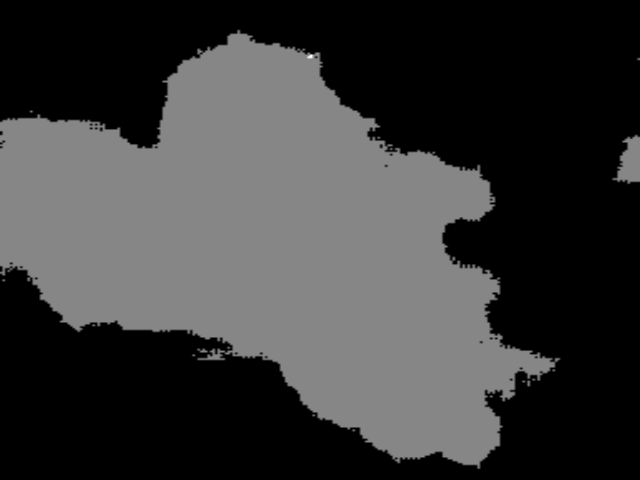

In [232]:
tf.keras.preprocessing.image.array_to_img(mk)


In [209]:
tf.print(tf.reshape(mk, shape=(256,256)), summarize=256)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
tf.keras.preprocessing.image.save_img(mk)

In [196]:
path = test_path + "5c569a019e6fe7be42d3f91f437fd011598594a456a76245c8e28b1bbcbdcf30" +'/'
image = imread(path +'frame0000.png')[:,:]
    

In [197]:
image

array([[103, 101, 103, ..., 174, 171, 159],
       [103,  98, 100, ..., 215, 214, 201],
       [104,  99, 102, ..., 219, 222, 215],
       ...,
       [ 72,  71,  75, ..., 115, 112, 115],
       [ 81,  84,  90, ..., 114, 111, 114],
       [103, 103, 110, ..., 113, 115, 113]], dtype=uint8)

In [198]:
image.shape

(384, 512)